In [1]:
from models.unet_fft import UNet_FFT
from models.model import MiniUnet
from models.xrd_transformer import XRDTransformer
from models.model_patt import SuperResolutionUnet
import numpy as np
import torch
import torch.nn as nn
from utils.functions import (
    R_factor,
    get_state_dict,
    make_dicts,
    create_intensity_tensors
)
import matplotlib.pyplot as plt

weights_path = 'weights/UNet_Patt/only_synth/model.ckpt'
model = SuperResolutionUnet()
state_dict = get_state_dict(weights_path)
model.eval()
model.load_state_dict(state_dict, strict=True)

Dictionary loaded successfully


<All keys matched successfully>

In [2]:
import pandas as pd
import patterson_utils as pu

xrs = pu.create_random_structure()
print(xrs)

Unit cell: (7.6075, 9.88975, 12.9327, 90, 109, 90)
Space group: P 1 21 1 (No. 4)


In [3]:
int_calc = xrs.structure_factors(d_min=1.5).f_calc().sort().as_intensity_array()
miller_indices15 = np.array(int_calc.indices())

print(int_calc.data().as_numpy_array().shape, miller_indices15.shape)

(319,) (319, 3)


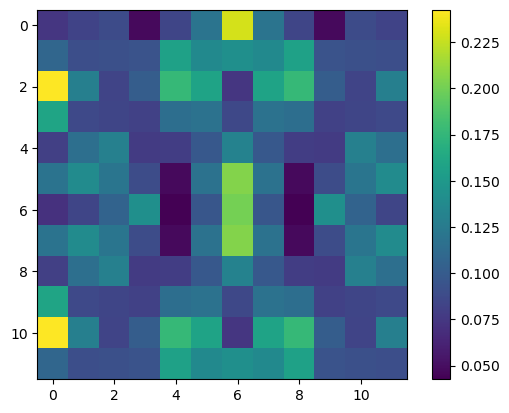

In [4]:
intensity15 = int_calc.data().as_numpy_array()

patt_15 = pu.calculate_patterson_fft(intensity15, miller_indices15, map_shape=(12, 12, 12))

plt.imshow(patt_15[patt_15.shape[0]//2, :, :])
plt.colorbar()
plt.show()

(1034,) (1034, 3)


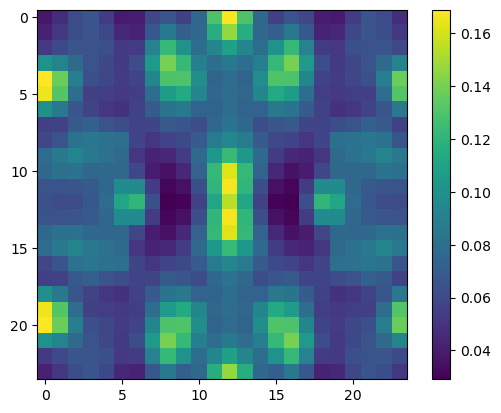

In [5]:
int_calc = xrs.structure_factors(d_min=1.0).f_calc().sort().as_intensity_array()
miller_indices10 = np.array(int_calc.indices())

print(int_calc.data().as_numpy_array().shape, miller_indices10.shape)
intensity10 = int_calc.data().as_numpy_array()

patt_10 = pu.calculate_patterson_fft(intensity10, miller_indices10, map_shape=(24, 24, 24))

plt.imshow(patt_10[patt_10.shape[0]//2, :, :])
plt.colorbar()
plt.show()

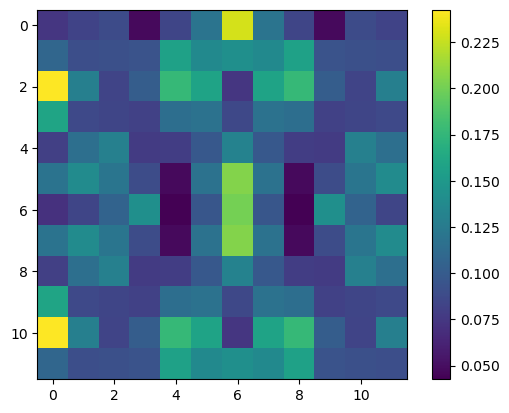

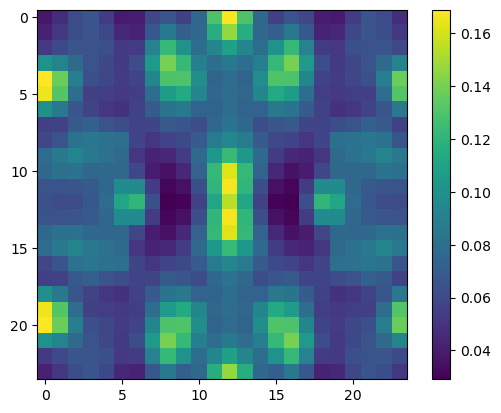

In [6]:
patt_15_tensor = torch.tensor((patt_15 - patt_15.min()) / (patt_15.max() - patt_15.min()))
patt_10_tensor = torch.tensor((patt_10 - patt_10.min()) / (patt_10.max() - patt_10.min()))

plt.imshow(patt_15_tensor[patt_15_tensor.shape[0]//2, :, :])
plt.colorbar()
plt.show()

plt.imshow(patt_10_tensor[patt_10_tensor.shape[0]//2, :, :])
plt.colorbar()
plt.show()

In [7]:
patt_15_tensor = patt_15_tensor.unsqueeze(0).unsqueeze(0).float()

patt_10_tensor_recon = model(patt_15_tensor).detach().numpy()

patt_10_tensor_recon.shape



(1, 1, 24, 24, 24)

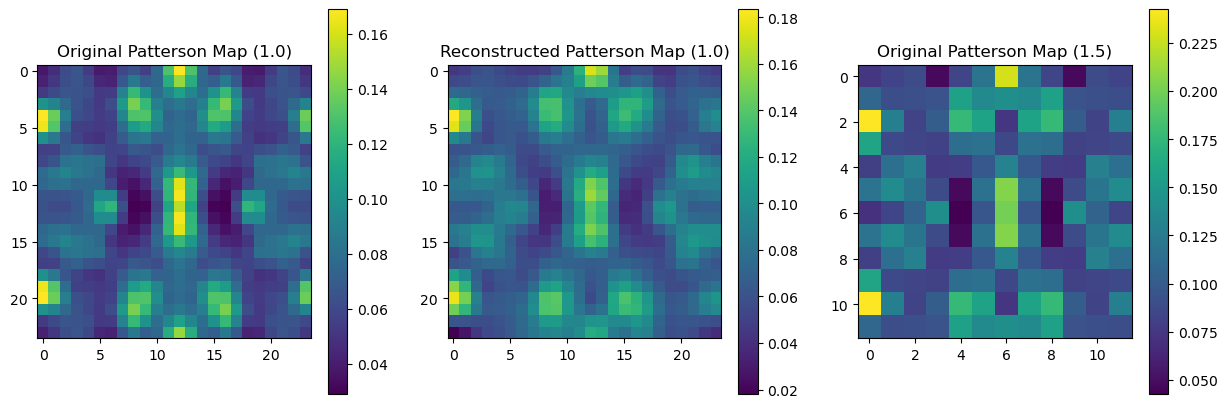

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(patt_10[patt_10.shape[0]//2, :, :])
ax1.set_title('Original Patterson Map (1.0)')
fig.colorbar(ax1.images[0], ax=ax1)

ax2.imshow(patt_10_tensor_recon[0, 0, patt_10_tensor_recon.shape[2]//2, :, :])
ax2.set_title('Reconstructed Patterson Map (1.0)') 
fig.colorbar(ax2.images[0], ax=ax2)

ax3.imshow(patt_15[patt_15.shape[0]//2, :, :])
ax3.set_title('Original Patterson Map (1.5)')
fig.colorbar(ax3.images[0], ax=ax3)
plt.show()


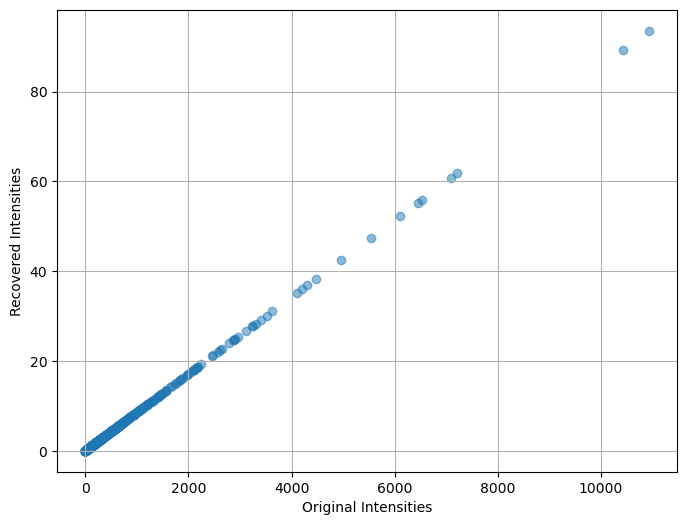

In [9]:
intensity_recovered_from_original = pu.recover_intensities_from_patterson(patt_10_tensor.detach().numpy(), miller_indices10)


plt.figure(figsize=(8, 6))
plt.scatter(intensity10, intensity_recovered_from_original, alpha=0.5)
plt.xlabel('Original Intensities')
plt.ylabel('Recovered Intensities')
plt.grid(True)
plt.show()

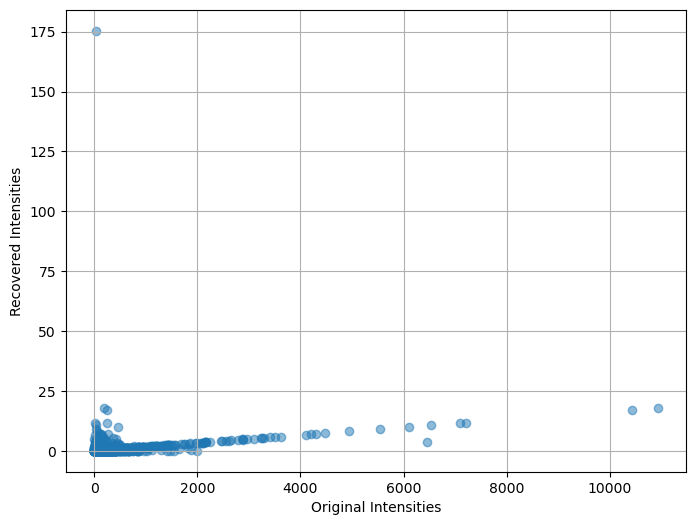

In [10]:
intensity_recovered_from_original = pu.recover_intensities_from_patterson(patt_15_tensor.detach().numpy()[0, 0, :, :, :], miller_indices10)


plt.figure(figsize=(8, 6))
plt.scatter(intensity10, intensity_recovered_from_original, alpha=0.5)
plt.xlabel('Original Intensities')
plt.ylabel('Recovered Intensities')
plt.grid(True)
plt.show()

100%|██████████| 10000/10000 [09:13<00:00, 18.08it/s]


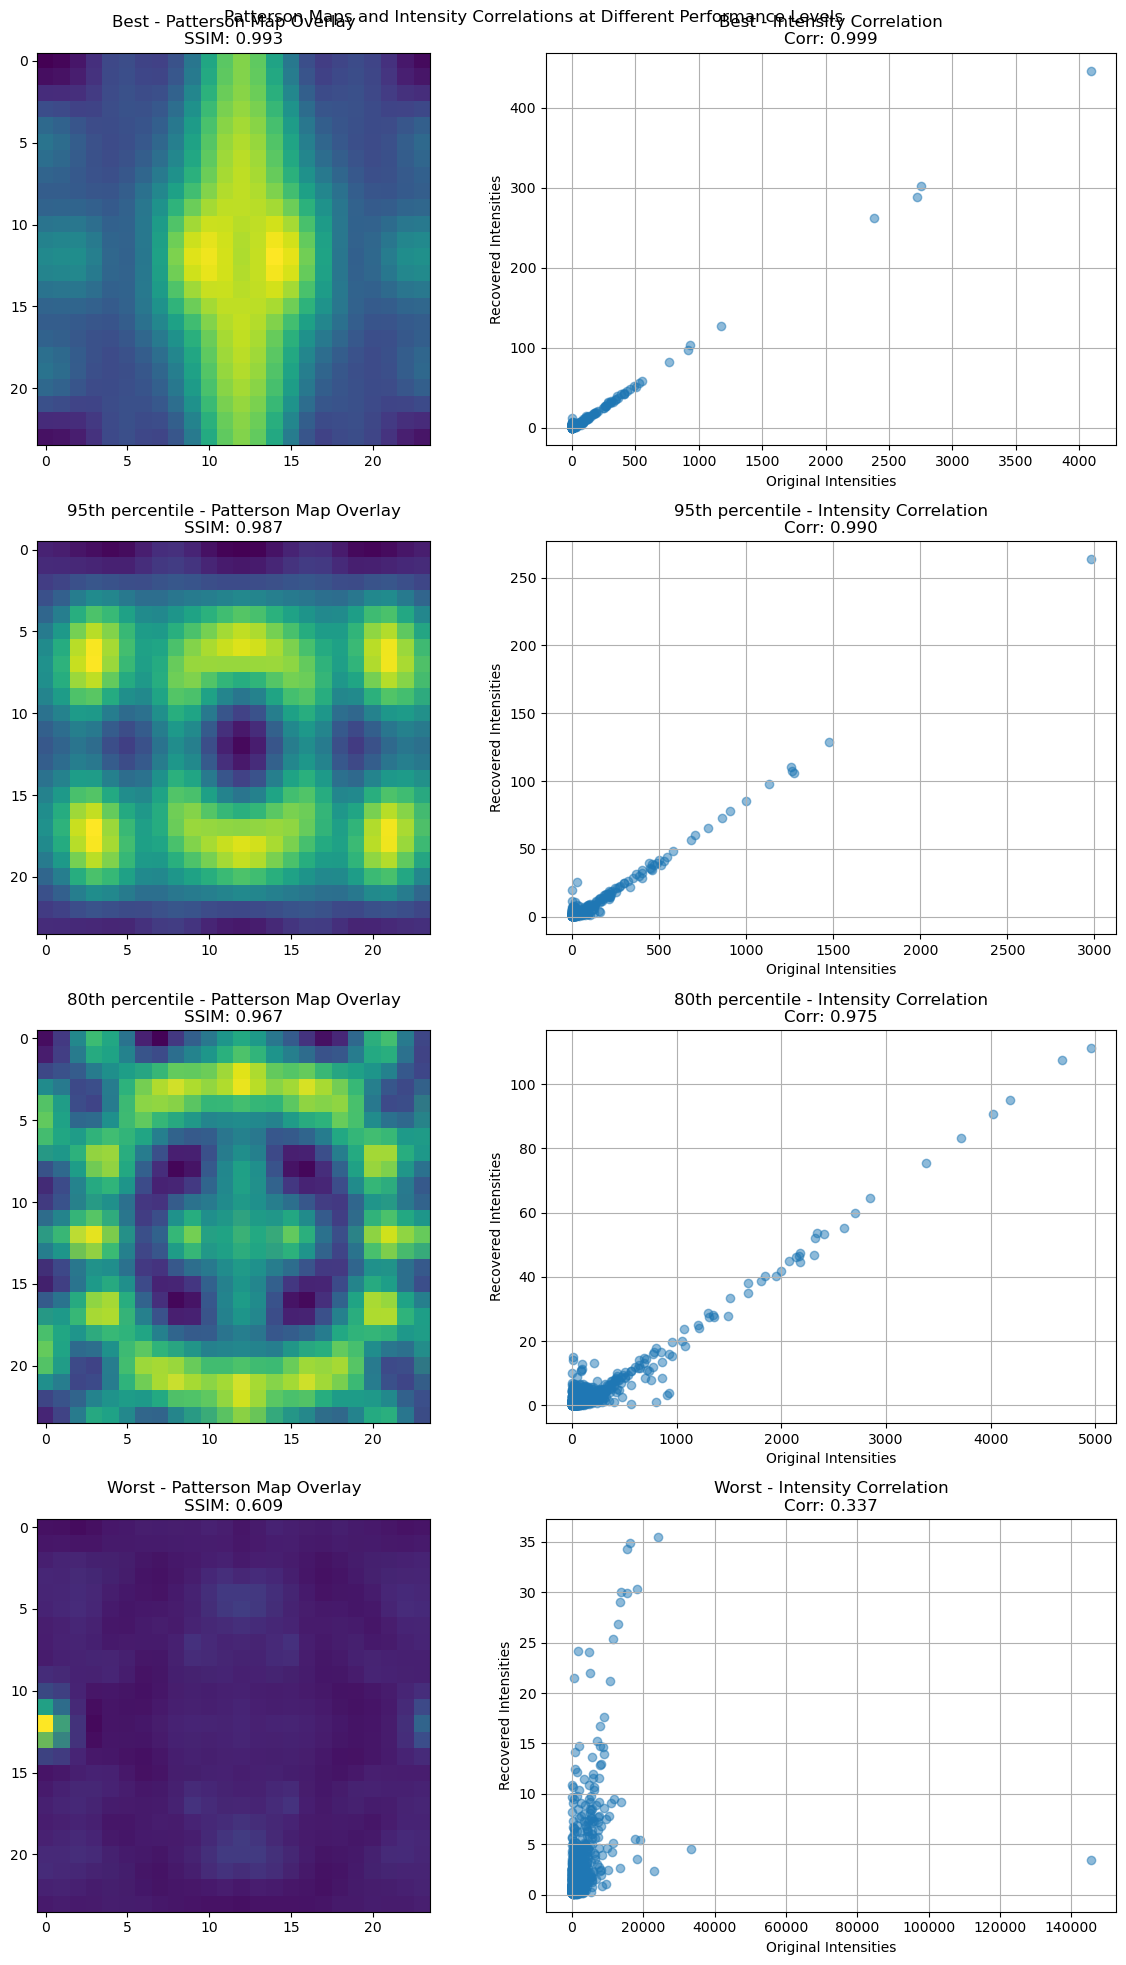

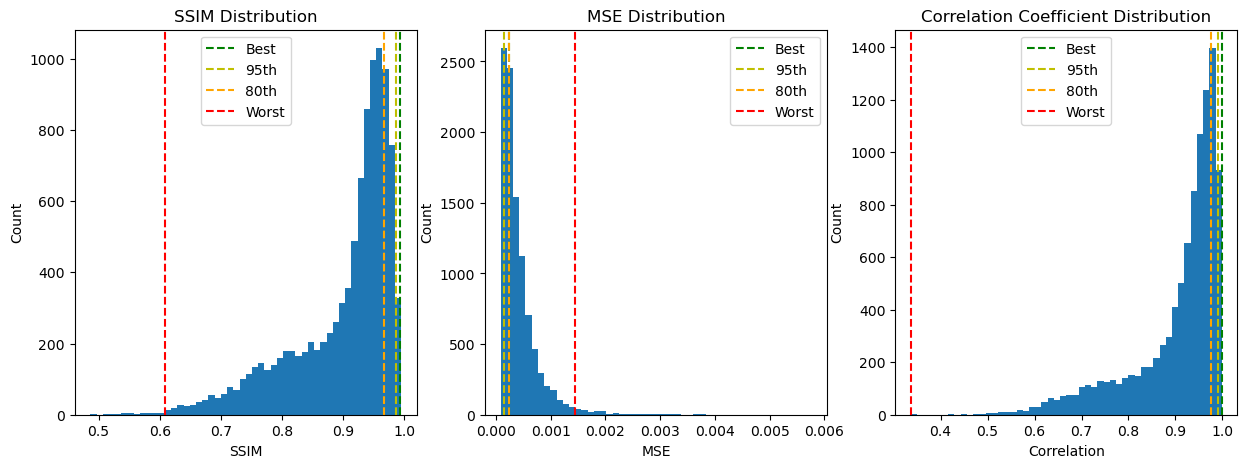


Summary Statistics:
SSIM - Mean: 0.9005, Std: 0.0836
MSE - Mean: 0.0004, Std: 0.0004
Correlation - Mean: 0.9032, Std: 0.0965


<Figure size 640x480 with 0 Axes>

In [22]:
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import tqdm
iterations = 10000

# Initialize arrays to store metrics
ssim_scores = np.zeros(iterations)
mse_scores = np.zeros(iterations)
corr_coeffs = np.zeros(iterations)

# Arrays to store patterns and intensities
all_patt_orig = []
all_patt_recon = []
all_int_orig = []
all_int_recon = []

# Loop through iterations
for i in tqdm.tqdm(range(iterations)):
    # Create random structure
    xrs = pu.create_random_structure()
    
    # Calculate Patterson map for d_min=1.5
    int_calc_15 = xrs.structure_factors(d_min=1.5).f_calc().sort().as_intensity_array()
    miller_indices15 = np.array(int_calc_15.indices())
    intensity15 = int_calc_15.data().as_numpy_array()
    patt_15 = pu.calculate_patterson_fft(intensity15, miller_indices15, map_shape=(12, 12, 12))
    
    # Calculate Patterson map for d_min=1.0 (ground truth)
    int_calc_10 = xrs.structure_factors(d_min=1.0).f_calc().sort().as_intensity_array()
    miller_indices10 = np.array(int_calc_10.indices())
    intensity10 = int_calc_10.data().as_numpy_array()
    patt_10 = pu.calculate_patterson_fft(intensity10, miller_indices10, map_shape=(24, 24, 24))
    
    # Normalize and prepare input for model
    patt_15_tensor = torch.tensor((patt_15 - patt_15.min()) / (patt_15.max() - patt_15.min()))
    patt_15_tensor = patt_15_tensor.unsqueeze(0).unsqueeze(0).float()
    
    # Get model prediction
    with torch.no_grad():
        patt_10_recon = model(patt_15_tensor).numpy()[0, 0]
    
    # Normalize ground truth for comparison
    patt_10_norm = (patt_10 - patt_10.min()) / (patt_10.max() - patt_10.min())
    
    # Convert to PyTorch tensors for SSIM
    patt_10_norm_tensor = torch.from_numpy(patt_10_norm).unsqueeze(0).unsqueeze(0).float()
    patt_10_recon_tensor = torch.from_numpy(patt_10_recon).unsqueeze(0).unsqueeze(0).float()
    
    # Calculate SSIM and MSE
    ssim_scores[i] = ssim(patt_10_norm_tensor, patt_10_recon_tensor, data_range=1.0,
                           size_average=True, nonnegative_ssim=True, win_size=5)
    mse_scores[i] = mean_squared_error(patt_10_norm.flatten(), patt_10_recon.flatten())
    
    # Recover intensities and calculate correlation
    intensity_recovered = pu.recover_intensities_from_patterson(patt_10_recon, miller_indices10)
    corr_coeffs[i] = pearsonr(intensity10, intensity_recovered)[0]
    
    # Store patterns and intensities
    all_patt_orig.append(patt_10_norm)
    all_patt_recon.append(patt_10_recon)
    all_int_orig.append(intensity10)
    all_int_recon.append(intensity_recovered)

# Get indices for different quantiles
best_idx = np.argmax(corr_coeffs)
worst_idx = np.argmin(corr_coeffs)
q95_idx = np.argsort(corr_coeffs)[int(0.95 * iterations)]
q80_idx = np.argsort(corr_coeffs)[int(0.80 * iterations)]

# Create visualization of patterns and intensities
fig1, axes1 = plt.subplots(4, 2, figsize=(12, 20))
fig1.suptitle('Patterson Maps and Intensity Correlations at Different Performance Levels')

# Plot patterns and intensities for each case
cases = [(best_idx, 'Best'), (q95_idx, '95th percentile'), 
         (q80_idx, '80th percentile'), (worst_idx, 'Worst')]

for i, (idx, title) in enumerate(cases):
    # Plot Patterson maps
    axes1[i,0].imshow(all_patt_orig[idx][all_patt_orig[idx].shape[0]//2,:,:])
    axes1[i,0].imshow(all_patt_recon[idx][all_patt_recon[idx].shape[0]//2,:,:], alpha=0.5)
    axes1[i,0].set_title(f'{title} - Patterson Map Overlay\nSSIM: {ssim_scores[idx]:.3f}')
    
    # Plot intensity correlation
    axes1[i,1].scatter(all_int_orig[idx], all_int_recon[idx], alpha=0.5)
    axes1[i,1].set_xlabel('Original Intensities')
    axes1[i,1].set_ylabel('Recovered Intensities')
    axes1[i,1].set_title(f'{title} - Intensity Correlation\nCorr: {corr_coeffs[idx]:.3f}')
    axes1[i,1].grid(True)
plt.savefig('only_synth_patt_unet.png')
plt.tight_layout()
plt.show()

# Plot distributions
fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.hist(ssim_scores, bins=50)
ax1.axvline(ssim_scores[best_idx], color='g', linestyle='--', label='Best')
ax1.axvline(ssim_scores[q95_idx], color='y', linestyle='--', label='95th')
ax1.axvline(ssim_scores[q80_idx], color='orange', linestyle='--', label='80th')
ax1.axvline(ssim_scores[worst_idx], color='r', linestyle='--', label='Worst')
ax1.set_title('SSIM Distribution')
ax1.set_xlabel('SSIM')
ax1.set_ylabel('Count')
ax1.legend()

ax2.hist(mse_scores, bins=50)
ax2.axvline(mse_scores[best_idx], color='g', linestyle='--', label='Best')
ax2.axvline(mse_scores[q95_idx], color='y', linestyle='--', label='95th')
ax2.axvline(mse_scores[q80_idx], color='orange', linestyle='--', label='80th')
ax2.axvline(mse_scores[worst_idx], color='r', linestyle='--', label='Worst')
ax2.set_title('MSE Distribution')
ax2.set_xlabel('MSE')
ax2.set_ylabel('Count')
ax2.legend()

ax3.hist(corr_coeffs, bins=50)
ax3.axvline(corr_coeffs[best_idx], color='g', linestyle='--', label='Best')
ax3.axvline(corr_coeffs[q95_idx], color='y', linestyle='--', label='95th')
ax3.axvline(corr_coeffs[q80_idx], color='orange', linestyle='--', label='80th')
ax3.axvline(corr_coeffs[worst_idx], color='r', linestyle='--', label='Worst')
ax3.set_title('Correlation Coefficient Distribution')
ax3.set_xlabel('Correlation')
ax3.set_ylabel('Count')
ax3.legend()
plt.savefig('only_synth_patt_unet_stats.png')
plt.show()


# Print summary statistics
print("\nSummary Statistics:")
print(f"SSIM - Mean: {np.mean(ssim_scores):.4f}, Std: {np.std(ssim_scores):.4f}")
print(f"MSE - Mean: {np.mean(mse_scores):.4f}, Std: {np.std(mse_scores):.4f}")
print(f"Correlation - Mean: {np.mean(corr_coeffs):.4f}, Std: {np.std(corr_coeffs):.4f}")